In [9]:
import pandas as pd
import numpy as np
import tensorflow_decision_forests as tfdf
import tensorflow as tf
import math
import plotly.express as px
import os

from sklearn.metrics import mean_absolute_error, mean_squared_error
from tensorflow.keras.callbacks import EarlyStopping

In [10]:
def load_data_for_regression(filename, nrows=None):
	data = pd.read_csv(filename, nrows=nrows)
	# data.rename(columns={"CH": "Curah Hujan"}, inplace=True)
	return data

# PREPROCESSING DATA
def preprocessed_data(dataframe):
	# Fill missing values in QFF Column
	dataframe['QFF'].fillna(dataframe['QFF'].mean(), inplace=True)
	return dataframe

def split_dataset(dataset, test_ratio):
	test_indices = np.random.rand(len(dataset)) < test_ratio
	return dataset[~test_indices], dataset[test_indices]

def neural_network_model(features):
	normalizer = tf.keras.layers.Normalization(axis=-1)
	normalizer.adapt(np.array(features))
	model = tf.keras.Sequential([normalizer, 
								tf.keras.layers.Dense(256, activation=tf.nn.relu),
								tf.keras.layers.Dropout(0.5),
								tf.keras.layers.Dense(256, activation=tf.nn.relu),
                  				tf.keras.layers.Dropout(0.5),
								tf.keras.layers.Dense(128, activation=tf.nn.relu),
                  				tf.keras.layers.Dropout(0.5),
								tf.keras.layers.Dense(1)])
	return model

def train_neural_network(dt_train_features, dt_train_labels, dt_test_features, dt_test_labels):
	early_stop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)
	model = neural_network_model(dt_train_features)
	model.compile(metrics=["mae", "mse"],
				        loss=["mean_absolute_error", "mean_squared_error"],
				        optimizer=tf.keras.optimizers.Adam(learning_rate=0.01))
	training = model.fit(dt_train_labels, dt_train_labels, validation_split=0.1, epochs=500, verbose=1, callbacks=[early_stop])
	evaluation = model.evaluate(dt_test_features, dt_test_labels, verbose=0)
	return model, evaluation

def random_forest_model():
	model = tfdf.keras.RandomForestModel(task=tfdf.keras.Task.REGRESSION)

	return model

def train_random_forest(train_dataframe, test_dataframe, str_label):
	train_ds = tfdf.keras.pd_dataframe_to_tf_dataset(dataframe=train_dataframe, 
													label=str_label,
													task=tfdf.keras.Task.REGRESSION)
	test_ds = tfdf.keras.pd_dataframe_to_tf_dataset(dataframe=test_dataframe,
                                                  label=str_label,
                                                  task=tfdf.keras.Task.REGRESSION)
	model = random_forest_model()
	model.compile(metrics=["mae", "mse"])
	model.fit(x=train_ds)
	evaluation = model.evaluate(test_ds, return_dict=True)
	return model, evaluation

def gradient_boosting_model():
	model = tfdf.keras.GradientBoostedTreesModel(task=tfdf.keras.Task.REGRESSION)
	return model

def train_gradient_boosting(train_dataframe, test_dataframe, str_label):
	train_ds = tfdf.keras.pd_dataframe_to_tf_dataset(dataframe=train_dataframe, 
													 label=str_label,
													 task=tfdf.keras.Task.REGRESSION)
	test_ds = tfdf.keras.pd_dataframe_to_tf_dataset(dataframe=test_dataframe,
													label=str_label,
													task=tfdf.keras.Task.REGRESSION)
	model = gradient_boosting_model()
	model.compile(metrics=["mae", "mse"])
	model.fit(x=train_ds)
	evaluation = model.evaluate(test_ds, return_dict=True)
	return model, evaluation

In [11]:
dir = 'peramalan_cuaca_bmkg_dev/dataset/'
filename = 'fklim-ngrai-20112020-final.csv'
dirfile = os.path.join(dir, filename)
df = load_data_for_regression(filename=dirfile)
df = preprocessed_data(df)
results = pd.DataFrame(columns=['Model', 'MAE', 'MSE', 'RMSE'])
df.head()

,Date,Tahun,Bulan,Tanggal,T0700,T1300,T1800,Trata-rata,Tmax,Tmin,...,QFE,RH0700,RH1300,RH1800,RHrata-rata,ffrata-rata,dd,ffmax,ddmax,QFF
0,1/1/2011,2011,1,1,25.1,27.0,26.4,25.9,29.0,24.7,...,1004.1,95,90,86,92,3,90,8.0,70,1010.36396
1,2/1/2011,2011,1,2,26.4,30.6,26.9,27.6,30.6,25.5,...,1005.9,86,75,90,84,4,320,12.0,290,1010.36396
2,3/1/2011,2011,1,3,25.4,30.3,26.0,26.8,31.2,24.8,...,1005.6,93,77,91,89,3,90,8.0,50,1010.36396
3,4/1/2011,2011,1,4,25.2,28.6,28.3,26.8,29.5,24.4,...,1005.6,93,82,75,86,4,270,10.0,270,1010.36396
4,5/1/2011,2011,1,5,24.6,30.8,27.2,26.8,31.7,24.1,...,1005.3,88,72,89,84,3,50,24.0,30,1010.36396


In [13]:
dropped_cols = ['Date', 'Tahun', 'Bulan', 'Tanggal', 'Cuaca Khusus']
df_pre = df.copy()
df_pre.drop(dropped_cols, axis=1, inplace=True)
df_pre.head()

,T0700,T1300,T1800,Trata-rata,Tmax,Tmin,CH,LPM,QFE,RH0700,RH1300,RH1800,RHrata-rata,ffrata-rata,dd,ffmax,ddmax,QFF
0,25.1,27.0,26.4,25.9,29.0,24.7,1.0,33,1004.1,95,90,86,92,3,90,8.0,70,1010.36396
1,26.4,30.6,26.9,27.6,30.6,25.5,0.8,46,1005.9,86,75,90,84,4,320,12.0,290,1010.36396
2,25.4,30.3,26.0,26.8,31.2,24.8,0.8,63,1005.6,93,77,91,89,3,90,8.0,50,1010.36396
3,25.2,28.6,28.3,26.8,29.5,24.4,0.0,35,1005.6,93,82,75,86,4,270,10.0,270,1010.36396
4,24.6,30.8,27.2,26.8,31.7,24.1,5.3,71,1005.3,88,72,89,84,3,50,24.0,30,1010.36396


In [7]:
desc = pd.DataFrame(df_pre.describe().T)
desc.to_csv('peramalan_cuaca_bmkg_dev/dataset/desc.csv')

In [14]:
# Split the dataset into a training and testing dataset.
train_ds_pd, test_ds_pd = split_dataset(dataset=df_pre, test_ratio=0.2)
print("{} examples in training, {} examples for testing.".format(len(train_ds_pd), len(test_ds_pd)))
train_ds_pd.columns

2950 examples in training, 703 examples for testing.


Index(['T0700', 'T1300', 'T1800', 'Trata-rata', 'Tmax', 'Tmin', 'CH', 'LPM',
       'QFE', 'RH0700', 'RH1300', 'RH1800', 'RHrata-rata', 'ffrata-rata', 'dd',
       'ffmax', 'ddmax', 'QFF'],
      dtype='object')

In [8]:
train_ds_pd.head()

,T0700,T1300,T1800,Trata-rata,Tmax,Tmin,CH,LPM,QFE,RH0700,RH1300,RH1800,RHrata-rata,ffrata-rata,dd,ffmax,ddmax,QFF
0,25.1,27.0,26.4,25.9,29.0,24.7,1.0,33,1004.1,95,90,86,92,3,90,8.0,70,1010.36396
1,26.4,30.6,26.9,27.6,30.6,25.5,0.8,46,1005.9,86,75,90,84,4,320,12.0,290,1010.36396
2,25.4,30.3,26.0,26.8,31.2,24.8,0.8,63,1005.6,93,77,91,89,3,90,8.0,50,1010.36396
3,25.2,28.6,28.3,26.8,29.5,24.4,0.0,35,1005.6,93,82,75,86,4,270,10.0,270,1010.36396
5,25.4,30.0,28.4,27.3,30.8,24.5,21.8,63,1006.1,91,81,83,87,3,270,15.0,270,1010.36396


# Using Neural Network Deep Learning with Tensorflow 

In [15]:
feature_cols = df_pre.columns
label_col = ['CH']
feature_cols = [i for i in feature_cols if i not in label_col]

# Split features from labels
train_features = train_ds_pd[feature_cols].copy()
test_features = test_ds_pd[feature_cols].copy()
train_labels = train_ds_pd[label_col].copy()
test_labels = test_ds_pd[label_col].copy()

train_features.head()

,T0700,T1300,T1800,Trata-rata,Tmax,Tmin,LPM,QFE,RH0700,RH1300,RH1800,RHrata-rata,ffrata-rata,dd,ffmax,ddmax,QFF
0,25.1,27.0,26.4,25.9,29.0,24.7,33,1004.1,95,90,86,92,3,90,8.0,70,1010.36396
1,26.4,30.6,26.9,27.6,30.6,25.5,46,1005.9,86,75,90,84,4,320,12.0,290,1010.36396
2,25.4,30.3,26.0,26.8,31.2,24.8,63,1005.6,93,77,91,89,3,90,8.0,50,1010.36396
3,25.2,28.6,28.3,26.8,29.5,24.4,35,1005.6,93,82,75,86,4,270,10.0,270,1010.36396
4,24.6,30.8,27.2,26.8,31.7,24.1,71,1005.3,88,72,89,84,3,50,24.0,30,1010.36396


In [16]:
tf.keras.backend.clear_session()
nn_model, evaluation = train_neural_network(dt_train_features=train_features, 
                                            dt_train_labels=train_labels, 
                                            dt_test_features=test_features, 
                                            dt_test_labels=test_labels)

2021-12-21 18:30:18.577676: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:925] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2021-12-21 18:30:18.579131: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-12-21 18:30:18.579289: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory
2021-12-21 18:30:18.579345: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublasLt.so.11: cannot open shared object file: No such file or directory
2021-12-21 18:30:18.579410: W tensorflow/stream_executor/platform/default/dso_loader.cc:6

Epoch 1/500
83/83 [==============================] - 2s 16ms/step - loss: 13.4716 - mae: 13.4716 - mse: 1882.7518 - val_loss: 4.1317 - val_mae: 4.1317 - val_mse: 120.9917
Epoch 2/500
83/83 [==============================] - 0s 5ms/step - loss: 4.2887 - mae: 4.2887 - mse: 204.7232 - val_loss: 2.1072 - val_mae: 2.1072 - val_mse: 19.5386
Epoch 3/500
83/83 [==============================] - 0s 5ms/step - loss: 3.4987 - mae: 3.4987 - mse: 128.0548 - val_loss: 1.5012 - val_mae: 1.5012 - val_mse: 12.7707
Epoch 4/500
83/83 [==============================] - 0s 5ms/step - loss: 3.3676 - mae: 3.3676 - mse: 119.6988 - val_loss: 1.7905 - val_mae: 1.7905 - val_mse: 13.8364
Epoch 5/500
83/83 [==============================] - 0s 5ms/step - loss: 3.2469 - mae: 3.2469 - mse: 215.7869 - val_loss: 2.7255 - val_mae: 2.7255 - val_mse: 49.8935
Epoch 6/500
83/83 [==============================] - 0s 4ms/step - loss: 3.5139 - mae: 3.5139 - mse: 128.2833 - val_loss: 3.1472 - val_mae: 3.1472 - val_mse: 61.3195

In [12]:
new_row = {'Model': 'Neural Network Baseline', 'MAE': evaluation[1], 'MSE': evaluation[2], 'RMSE': np.sqrt(evaluation[2])}
results = results.append(new_row, ignore_index=True)
results

,Model,MAE,MSE,RMSE
0,Neural Network Baseline,4.840593,174.678192,13.216588


In [14]:
nn_model.save("peramalan_cuaca_bmkg_dev/models/neuralnetwork-baseline")

INFO:tensorflow:Assets written to: peramalan_cuaca_bmkg_dev/models/neuralnetwork-baseline/assets


INFO:tensorflow:Assets written to: peramalan_cuaca_bmkg_dev/models/neuralnetwork-baseline/assets


In [20]:
pred_data = {
    'T0700': [30.1], 
    'T1300': [25.3], 
    'Trata-rata': [26.8],
    'T1800': [17.4], 
    'Tmax': [29.5],
    'Tmin': [22.4], 
    'LPM': [48], 
    'QFE': [1004.1], 
    'RH0700': [93],
    'RH1300': [82],
    'RH1800': [77], 
    'RHrata-rata': [86],
    'ffrata-rata': [4],
    'dd': [270],
    'ffmax': [10.0],
    'ddmax': [270],
    'QFF': [1010.36396]
}
pred_data = pd.DataFrame(pred_data)
print(pred_data)
# pred_data = {'normalization_input':[30.1, 25.3, 17.4, 22.4, 1004.1, 48, 77, 29.9]}
pred_result = nn_model.predict(pred_data).flatten()
print(pred_result)

   T0700  T1300  Trata-rata  T1800  Tmax  Tmin  LPM     QFE  RH0700  RH1300  \
0   30.1   25.3        26.8   17.4  29.5  22.4   48  1004.1      93      82   

   RH1800  RHrata-rata  ffrata-rata   dd  ffmax  ddmax         QFF  
0      77           86            4  270   10.0    270  1010.36396  
[0.07972205]


In [26]:
nn_model.save("peramalan-cuaca-bmkg/models/neuralnetwork-dummy")
nn_model.save_weights("peramalan-cuaca-bmkg/models/neuralnetwork-dummy-weights")
nn_ = tf.keras.models.load_model("peramalan-cuaca-bmkg/models/neuralnetwork-dummy")
nn_.load_weights("peramalan-cuaca-bmkg/models/neuralnetwork-dummy-weights")
nn_.summary()

INFO:tensorflow:Assets written to: peramalan-cuaca-bmkg/models/neuralnetwork-dummy/assets


INFO:tensorflow:Assets written to: peramalan-cuaca-bmkg/models/neuralnetwork-dummy/assets


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization (Normalizatio  (None, 17)               35        
 n)                                                              
                                                                 
 dense (Dense)               (None, 256)               4608      
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 256)               65792     
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_2 (Dense)             (None, 128)               32896     
                                                        

In [51]:
tf.keras.utils.plot_model(nn_model)

('You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) ', 'for plot_model/model_to_dot to work.')


In [28]:
pred_result = nn_.predict(pred_data).flatten()
pred_result

array([0.07972205], dtype=float32)

# Tensorflow RandomForest

In [17]:
# RandomForest
rf_model, evaluation = train_random_forest(train_dataframe=train_ds_pd, test_dataframe=test_ds_pd, str_label="CH")

/home/rudy/Codes/Python/streamlit/lib/python3.8/site-packages/tensorflow_decision_forests/keras/core.py:1612: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  features_dataframe = dataframe.drop(label, 1)


47/47 [==============================] - ETA: 0s

[INFO kernel.cc:736] Start Yggdrasil model training
[INFO kernel.cc:737] Collect training examples
[INFO kernel.cc:392] Number of batches: 47
[INFO kernel.cc:393] Number of examples: 2950
[INFO kernel.cc:759] Dataset:
Number of records: 2950
Number of columns: 18

Number of columns by type:
	NUMERICAL: 18 (100%)

Columns:

NUMERICAL: 18 (100%)
	0: "LPM" NUMERICAL mean:70.9827 min:0 max:100 sd:35.9649
	1: "QFE" NUMERICAL mean:1009.74 min:1001.7 max:1015.2 sd:2.05331
	2: "QFF" NUMERICAL mean:1010.35 min:1002.1 max:1015.7 sd:1.88777
	3: "RH0700" NUMERICAL mean:85.6529 min:61 max:100 sd:5.82661
	4: "RH1300" NUMERICAL mean:71.3542 min:48 max:99 sd:6.60659
	5: "RH1800" NUMERICAL mean:77.6614 min:59 max:98 sd:5.59905
	6: "RHrata-rata" NUMERICAL mean:80.2051 min:63 max:99 sd:4.7512
	7: "T0700" NUMERICAL mean:25.9021 min:19.8 max:29.2 sd:1.32416
	8: "T1300" NUMERICAL mean:29.579 min:22.5 max:33.6 sd:1.39057
	9: "T1800" NUMERICAL mean:27.9085 min:22.2 max:31.8 sd:1.34305
	10: "Tmax" NUMERICAL me

47/47 [==============================] - 5s 40ms/step


[INFO decision_forest.cc:590] Model loaded with 300 root(s), 155564 node(s), and 17 input feature(s).
[INFO abstract_model.cc:993] Engine "RandomForestOptPred" built
[INFO kernel.cc:848] Use fast generic engine


11/11 [==============================] - 0s 6ms/step - loss: 0.0000e+00 - mae: 4.6770 - mse: 95.6013


In [45]:
rf_model.save("peramalan_cuaca_bmkg_dev/models/randomforest-baseline")

INFO:tensorflow:Assets written to: peramalan_cuaca_bmkg_dev/models/randomforest-baseline/assets


INFO:tensorflow:Assets written to: peramalan_cuaca_bmkg_dev/models/randomforest-baseline/assets


In [56]:
tfdf.model_plotter.plot_tree(rf_model)

AttributeError: 'RandomForestModel' object has no attribute 'root'

In [16]:
print(evaluation)
print('\n')
print(f"MAE: {evaluation['mae']}")
print(f"MSE: {evaluation['mse']}")
print(f"RMSE: {math.sqrt(evaluation['mse'])}")

{'loss': 0.0, 'mae': 4.861850261688232, 'mse': 94.56256103515625}


MAE: 4.861850261688232
MSE: 94.56256103515625
RMSE: 9.724328307659931


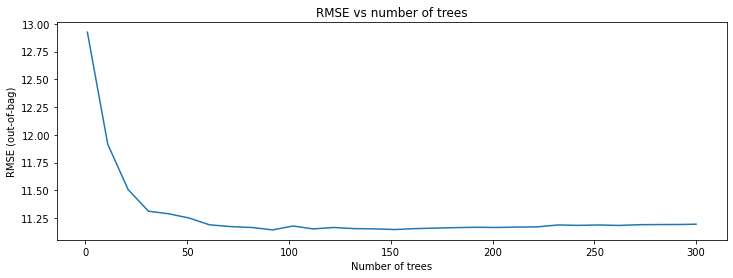

In [17]:
import matplotlib.pyplot as plt

logs = rf_model.make_inspector().training_logs()

plt.figure(figsize=(12, 4))

plt.plot([log.num_trees for log in logs], [log.evaluation.rmse for log in logs])
plt.xlabel("Number of trees")
plt.ylabel("RMSE (out-of-bag)")
plt.title("RMSE vs number of trees")

plt.show()

In [18]:
new_row = {'Model': 'TF-RandomForest-Baseline', 'MAE': evaluation['mae'], 'MSE': evaluation['mse'], 'RMSE': np.sqrt(evaluation['mse'])}
results = results.append(new_row, ignore_index=True)
results

,Model,MAE,MSE,RMSE
0,Neural Network Baseline,4.840593,174.678192,13.216588
1,TF-RandomForest-Baseline,4.861850,94.562561,9.724328


# GradientBoostedTree

In [18]:
gbt_model, evaluation = train_gradient_boosting(train_dataframe=train_ds_pd, test_dataframe=test_ds_pd, str_label="CH")

31/47 [==================>...........] - ETA: 0s

[INFO kernel.cc:736] Start Yggdrasil model training
[INFO kernel.cc:737] Collect training examples
[INFO kernel.cc:392] Number of batches: 47
[INFO kernel.cc:393] Number of examples: 2950
[INFO kernel.cc:759] Dataset:
Number of records: 2950
Number of columns: 18

Number of columns by type:
	NUMERICAL: 18 (100%)

Columns:

NUMERICAL: 18 (100%)
	0: "LPM" NUMERICAL mean:70.9827 min:0 max:100 sd:35.9649
	1: "QFE" NUMERICAL mean:1009.74 min:1001.7 max:1015.2 sd:2.05331
	2: "QFF" NUMERICAL mean:1010.35 min:1002.1 max:1015.7 sd:1.88777
	3: "RH0700" NUMERICAL mean:85.6529 min:61 max:100 sd:5.82661
	4: "RH1300" NUMERICAL mean:71.3542 min:48 max:99 sd:6.60659
	5: "RH1800" NUMERICAL mean:77.6614 min:59 max:98 sd:5.59905
	6: "RHrata-rata" NUMERICAL mean:80.2051 min:63 max:99 sd:4.7512
	7: "T0700" NUMERICAL mean:25.9021 min:19.8 max:29.2 sd:1.32416
	8: "T1300" NUMERICAL mean:29.579 min:22.5 max:33.6 sd:1.39057
	9: "T1800" NUMERICAL mean:27.9085 min:22.2 max:31.8 sd:1.34305
	10: "Tmax" NUMERICAL me

47/47 [==============================] - 1s 20ms/step


[INFO gradient_boosted_trees.cc:2740] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 11.9438
[INFO gradient_boosted_trees.cc:229] Truncates the model to 36 tree(s) i.e. 36  iteration(s).
[INFO gradient_boosted_trees.cc:263] Final model num-trees:36 valid-loss:11.943823 valid-rmse:11.943823
[INFO kernel.cc:828] Export model in log directory: /tmp/tmpel0h3ugl
[INFO kernel.cc:836] Save model in resources
[INFO kernel.cc:988] Loading model from path
[INFO abstract_model.cc:993] Engine "GradientBoostedTreesQuickScorerExtended" built
[INFO kernel.cc:848] Use fast generic engine


11/11 [==============================] - 0s 4ms/step - loss: 0.0000e+00 - mae: 4.7200 - mse: 99.0337


In [32]:
new_row = {'Model': 'TF-GradientBoostedTrees-Baseline', 'MAE': evaluation['mae'], 'MSE': evaluation['mse'], 'RMSE': np.sqrt(evaluation['mse'])}
results = results.append(new_row, ignore_index=True)
results

,Model,MAE,MSE,RMSE
0,Neural Network Baseline,4.840593,174.678192,13.216588
1,TF-RandomForest-Baseline,4.861850,94.562561,9.724328
2,TF-GradientBoostedTrees-Baseline,5.204072,99.039864,9.951877


In [46]:
gbt_model.save("peramalan_cuaca_bmkg_dev/models/gradientboostedtrees-baseline")

INFO:tensorflow:Assets written to: peramalan_cuaca_bmkg_dev/models/gradientboostedtrees-baseline/assets


INFO:tensorflow:Assets written to: peramalan_cuaca_bmkg_dev/models/gradientboostedtrees-baseline/assets


# XGBoost

In [19]:
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [20]:
def xgboost_model():
	hyper_params = {"tree_method":'gpu_hist',
					"n_estimators":2200, 
					"learning_rate":0.01,
					"seed":123,
					"max_depth":20,  
					"objective":'reg:squarederror',  
					"eval_metric":'mae',
					"verbosity":1,
					"booster":'gblinear',
					"reg_alpha":0.4640, 
					"reg_lambda":0.8571,
					"feature_selector":'cyclic',
					"random_state":111,
					"colsample_bytree":0.4603, 
					"gamma":0.0468, 
					"min_child_weight":1.7817,  
					"subsample":0.5213,
					"num_parallel_tree":1
	}
	model = XGBRegressor(**hyper_params)
	return model

def train_xgboost(df_train_features, df_test_features, df_train_label, df_test_label):
	model = xgboost_model()
	model.fit(df_train_features, df_train_label, verbose=2)
	predictions = model.predict(df_test_features)
	evaluation = [mean_absolute_error(df_test_label, predictions), mean_squared_error(df_test_label, predictions)]
	print(evaluation)
	return model, evaluation

In [21]:
# xgb_params = dict(
#     max_depth=6,           # maximum depth of each tree - try 2 to 10
#     learning_rate=0.01,    # effect of each tree - try 0.0001 to 0.1
#     n_estimators=1000,     # number of trees (that is, boosting rounds) - try 1000 to 8000
#     min_child_weight=1,    # minimum number of houses in a leaf - try 1 to 10
#     colsample_bytree=0.7,  # fraction of features (columns) per tree - try 0.2 to 1.0
#     subsample=0.7,         # fraction of instances (rows) per tree - try 0.2 to 1.0
#     reg_alpha=0.5,         # L1 regularization (like LASSO) - try 0.0 to 10.0
#     reg_lambda=1.0,        # L2 regularization (like Ridge) - try 0.0 to 10.0
#     num_parallel_tree=1,   # set > 1 for boosted random forests
# )
xgb_model, xgb_evaluation = train_xgboost(df_train_features=train_features, 
											df_test_features=test_features, 
											df_train_label=train_labels,  
											df_test_label=test_labels)

[18:31:10] WARNING: ../src/learner.cc:576: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight", "num_parallel_tree", "subsample", "tree_method" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[5.864603183279675, 116.73225865335525]


In [36]:
new_row = {'Model': 'XGBoost-Baseline', 'MAE': xgb_evaluation[0], 'MSE': xgb_evaluation[1], 'RMSE': np.sqrt(xgb_evaluation[1])}
results = results.append(new_row, ignore_index=True)
results

,Model,MAE,MSE,RMSE
0,Neural Network Baseline,4.840593,174.678192,13.216588
1,TF-RandomForest-Baseline,4.861850,94.562561,9.724328
2,TF-GradientBoostedTrees-Baseline,5.204072,99.039864,9.951877
3,XGBoost-Baseline,5.887146,118.535456,10.887399


In [43]:
xgb_model.save_model('peramalan_cuaca_bmkg_dev/models/xgb-model-baseline.txt')

In [44]:
model = XGBRegressor()
model.load_model('peramalan_cuaca_bmkg_dev/models/xgb-model-baseline.txt')

In [45]:
predic = model.predict(pred_data)
predic

array([9.205477], dtype=float32)

In [22]:
# Feature Importance in XGBoost
import xgboost as xgb

params = {
      'tree_method': 'gpu_hist',
      'n_estimators': 220, 
      'learning_rate': 0.1,
      'seed': 123,
      'max_depth': 20,  
      'objective': 'reg:squarederror',  
      'eval_metric': 'mae',
      'verbosity': 1,
      'random_state': 111

}

# params = {"objective":"reg:linear",'colsample_bytree': 0.3,'learning_rate': 0.1,
#                 'max_depth': 5, 'alpha': 10}

data_dmatrix = xgb.DMatrix(data=df_pre[feature_cols], label=df_pre[label_col])

xgb_feature_importance = xgb.train(params=params, dtrain=data_dmatrix, num_boost_round=10)

xgb.plot_importance(xgb_feature_importance)

[18:31:35] WARNING: ../src/learner.cc:576: 
Parameters: { "n_estimators" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




XGBoostError: [18:31:38] ../src/tree/updater_gpu_hist.cu:770: Exception in gpu_hist: [18:31:38] ../src/common/device_helpers.cuh:132: NCCL failure :unhandled system error ../src/common/device_helpers.cu(67)
Stack trace:
  [bt] (0) /home/rudy/Codes/Python/streamlit/lib/python3.8/site-packages/xgboost/lib/libxgboost.so(+0x31dc4d) [0x7fec2f63dc4d]
  [bt] (1) /home/rudy/Codes/Python/streamlit/lib/python3.8/site-packages/xgboost/lib/libxgboost.so(+0x320da9) [0x7fec2f640da9]
  [bt] (2) /home/rudy/Codes/Python/streamlit/lib/python3.8/site-packages/xgboost/lib/libxgboost.so(+0x31efaa) [0x7fec2f63efaa]
  [bt] (3) /home/rudy/Codes/Python/streamlit/lib/python3.8/site-packages/xgboost/lib/libxgboost.so(+0x4d7dc2) [0x7fec2f7f7dc2]
  [bt] (4) /home/rudy/Codes/Python/streamlit/lib/python3.8/site-packages/xgboost/lib/libxgboost.so(+0x4e1b86) [0x7fec2f801b86]
  [bt] (5) /home/rudy/Codes/Python/streamlit/lib/python3.8/site-packages/xgboost/lib/libxgboost.so(+0x17d4a3) [0x7fec2f49d4a3]
  [bt] (6) /home/rudy/Codes/Python/streamlit/lib/python3.8/site-packages/xgboost/lib/libxgboost.so(+0x17e027) [0x7fec2f49e027]
  [bt] (7) /home/rudy/Codes/Python/streamlit/lib/python3.8/site-packages/xgboost/lib/libxgboost.so(+0x1b481a) [0x7fec2f4d481a]
  [bt] (8) /home/rudy/Codes/Python/streamlit/lib/python3.8/site-packages/xgboost/lib/libxgboost.so(XGBoosterUpdateOneIter+0x68) [0x7fec2f3b94e8]



Stack trace:
  [bt] (0) /home/rudy/Codes/Python/streamlit/lib/python3.8/site-packages/xgboost/lib/libxgboost.so(+0x4c2e69) [0x7fec2f7e2e69]
  [bt] (1) /home/rudy/Codes/Python/streamlit/lib/python3.8/site-packages/xgboost/lib/libxgboost.so(+0x4e1edf) [0x7fec2f801edf]
  [bt] (2) /home/rudy/Codes/Python/streamlit/lib/python3.8/site-packages/xgboost/lib/libxgboost.so(+0x17d4a3) [0x7fec2f49d4a3]
  [bt] (3) /home/rudy/Codes/Python/streamlit/lib/python3.8/site-packages/xgboost/lib/libxgboost.so(+0x17e027) [0x7fec2f49e027]
  [bt] (4) /home/rudy/Codes/Python/streamlit/lib/python3.8/site-packages/xgboost/lib/libxgboost.so(+0x1b481a) [0x7fec2f4d481a]
  [bt] (5) /home/rudy/Codes/Python/streamlit/lib/python3.8/site-packages/xgboost/lib/libxgboost.so(XGBoosterUpdateOneIter+0x68) [0x7fec2f3b94e8]
  [bt] (6) /lib/x86_64-linux-gnu/libffi.so.7(+0x6ff5) [0x7fee397c8ff5]
  [bt] (7) /lib/x86_64-linux-gnu/libffi.so.7(+0x640a) [0x7fee397c840a]
  [bt] (8) /usr/lib/python3.8/lib-dynload/_ctypes.cpython-38-x86_64-linux-gnu.so(_ctypes_callproc+0x5b6) [0x7fee394b5306]



In [ ]:
# ['T0700', 'T1300', 'T1800', 'Tmin', 'QFE', 'LPM', 'RH1800', 'Tmax']

# LightGBM

In [23]:
import lightgbm as lgb

In [24]:
def lightgbm_model():
	hyper_params = {"task": "train",
					"boosting_type": "gbdt",
					"objective": "regression",
					"metric": ["l1", "l2"],
					"learning_rate": 0.01,
					"feature_fraction": 0.9,
					"bagging_fraction": 0.7,
					"bagging_freq": 10,
					"verbose": 0,
					"max_depth": 8,
					"num_leaves": 128,  
					"max_bin": 512,
					"num_iterations": 100000
					# "max_bin":55, 
					# "feature_fraction_seed":9, 
					# "bagging_seed":9,
					# "min_data_in_leaf":6, 
					# "min_sum_hessian_in_leaf":11,
	}
	model = lgb.LGBMRegressor(**hyper_params)
	return model

def train_lightgbm(df_train_features, df_test_features, df_train_label, df_test_label):
	model = lightgbm_model()
	model.fit(df_train_features, 
			  df_train_label,
			  eval_set=[(df_test_features, df_test_label)],
			  eval_metric='l2',
			  early_stopping_rounds=1000,
			  verbose=500
	)
	predictions = model.predict(df_test_features)
	evaluation = [mean_absolute_error(df_test_label, predictions), mean_squared_error(df_test_label, predictions)]
	print(evaluation)
	# st.write(evaluation)
	return model, evaluation

In [48]:
print(train_features.shape)
print(test_features.shape)
print(train_labels.shape)
print(test_labels.shape)

(2945, 17)
(708, 17)
(2945, 1)
(708, 1)


In [25]:
lgbm_model, lgbm_evaluation = train_lightgbm(df_train_features=train_features, 
											df_test_features=test_features, 
											df_train_label=train_labels,  
											df_test_label=test_labels)

/home/rudy/Codes/Python/streamlit/lib/python3.8/site-packages/lightgbm/engine.py:118: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 

In [60]:
new_row = {'Model': 'LightGBM-Baseline', 'MAE': lgbm_evaluation[0], 'MSE': lgbm_evaluation[1], 'RMSE': np.sqrt(lgbm_evaluation[1])}
results = results.append(new_row, ignore_index=True)
results

,Model,MAE,MSE,RMSE
0,Neural Network Baseline,4.840593,174.678192,13.216588
1,TF-RandomForest-Baseline,4.861850,94.562561,9.724328
2,TF-GradientBoostedTrees-Baseline,5.204072,99.039864,9.951877
3,XGBoost-Baseline,5.887146,118.535456,10.887399
4,LightGBM-Baseline,4.797606,93.799695,9.685024
5,Neural Network New Features,6.407674,179.125824,13.383790
6,TF-RandomForest-New-Feature,5.283699,146.764069,12.114622
7,LightGBM-Baseline,4.837427,95.448051,9.769752


In [44]:
lgbm_model.booster_.save_model('peramalan_cuaca_bmkg_dev/models/lgbm-model-baseline.txt')

In [54]:
model = lgb.Booster(model_file='peramalan_cuaca_bmkg_dev/models/lgbm-model-baseline.txt')
# model = lgbm_model.Booster(model_file='lgbm-model-dummy.txt')
prediction = model.predict(pred_data)
prediction

array([9.70560178])

# Improved Model using Feature Importance

In [47]:
new_features = ['RH1300', 'ffmax', 'RH1800', 'ddmax', 'T1800', 'dd', 'Tmax']
dt_train_nfeatures = train_ds_pd[new_features].copy()
dt_test_nfeatures = test_ds_pd[new_features].copy()

In [48]:
tf.keras.backend.clear_session()
nn_model_nfeatures, evaluation = train_neural_network(dt_train_features=dt_train_nfeatures, 
                                                    dt_train_labels=train_labels, 
                                                    dt_test_features=dt_test_nfeatures, 
                                                    dt_test_labels=test_labels)
new_row = {'Model': 'Neural Network New Features', 'MAE': evaluation[1], 'MSE': evaluation[2], 'RMSE': np.sqrt(evaluation[2])}
results = results.append(new_row, ignore_index=True)
results                                        

Epoch 1/500
81/81 [==============================] - 1s 8ms/step - loss: 3.2535 - mae: 3.2535 - mse: 107.7151 - val_loss: 1.7079 - val_mae: 1.7079 - val_mse: 19.0951
Epoch 2/500
81/81 [==============================] - 0s 5ms/step - loss: 2.2549 - mae: 2.2549 - mse: 55.0267 - val_loss: 2.5067 - val_mae: 2.5067 - val_mse: 35.5691
Epoch 3/500
81/81 [==============================] - 0s 4ms/step - loss: 2.1626 - mae: 2.1626 - mse: 49.1078 - val_loss: 1.7857 - val_mae: 1.7857 - val_mse: 14.3146
Epoch 4/500
81/81 [==============================] - 0s 4ms/step - loss: 2.1731 - mae: 2.1731 - mse: 56.9611 - val_loss: 2.2352 - val_mae: 2.2352 - val_mse: 28.5657
Epoch 5/500
81/81 [==============================] - 0s 5ms/step - loss: 2.3243 - mae: 2.3243 - mse: 58.5548 - val_loss: 2.0584 - val_mae: 2.0584 - val_mse: 23.3847
Epoch 6/500
81/81 [==============================] - 0s 5ms/step - loss: 2.1668 - mae: 2.1668 - mse: 47.4821 - val_loss: 1.3214 - val_mae: 1.3214 - val_mse: 6.7156
Epoch 7/50

,Model,MAE,MSE,RMSE
0,Neural Network Baseline,4.840593,174.678192,13.216588
1,TF-RandomForest-Baseline,4.861850,94.562561,9.724328
2,TF-GradientBoostedTrees-Baseline,5.204072,99.039864,9.951877
3,XGBoost-Baseline,5.887146,118.535456,10.887399
4,LightGBM-Baseline,4.797606,93.799695,9.685024
5,Neural Network New Features,6.407674,179.125824,13.383790


In [49]:
# RandomForest
new_features = ['RH1300', 'ffmax', 'RH1800', 'ddmax', 'T1800', 'dd', 'Tmax', 'CH']
train_ds_pd, test_ds_pd = split_dataset(dataset=df_pre[new_features], test_ratio=0.2)
rf_model, evaluation = train_random_forest(train_dataframe=train_ds_pd, test_dataframe=test_ds_pd, str_label="CH")
new_row = {'Model': 'TF-RandomForest-New-Feature', 'MAE': evaluation['mae'], 'MSE': evaluation['mse'], 'RMSE': np.sqrt(evaluation['mse'])}
results = results.append(new_row, ignore_index=True)
results

/home/rudy/Codes/Python/streamlit/lib/python3.8/site-packages/tensorflow_decision_forests/keras/core.py:1612: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  features_dataframe = dataframe.drop(label, 1)


40/46 [=========================>....] - ETA: 0s

[INFO kernel.cc:736] Start Yggdrasil model training
[INFO kernel.cc:737] Collect training examples
[INFO kernel.cc:392] Number of batches: 46
[INFO kernel.cc:393] Number of examples: 2887
[INFO kernel.cc:759] Dataset:
Number of records: 2887
Number of columns: 8

Number of columns by type:
	NUMERICAL: 8 (100%)

Columns:

NUMERICAL: 8 (100%)
	0: "RH1300" NUMERICAL mean:71.3214 min:48 max:99 sd:6.58765
	1: "RH1800" NUMERICAL mean:77.647 min:59 max:98 sd:5.50326
	2: "T1800" NUMERICAL mean:27.8988 min:23.8 max:31.8 sd:1.3482
	3: "Tmax" NUMERICAL mean:30.5297 min:26.4 max:35 sd:1.29937
	4: "dd" NUMERICAL mean:160.066 min:0 max:360 sd:77.446
	5: "ddmax" NUMERICAL mean:167.897 min:0 max:360 sd:79.6815
	6: "ffmax" NUMERICAL mean:17.0194 min:5 max:49 sd:5.12221
	7: "__LABEL" NUMERICAL mean:4.59189 min:0 max:145.6 sd:12.7218

Terminology:
	nas: Number of non-available (i.e. missing) values.
	ood: Out of dictionary.
	manually-defined: Attribute which type is manually defined by the user i.e. the 

46/46 [==============================] - 2s 31ms/step


[INFO decision_forest.cc:590] Model loaded with 300 root(s), 165796 node(s), and 7 input feature(s).
[INFO abstract_model.cc:993] Engine "RandomForestOptPred" built
[INFO kernel.cc:848] Use fast generic engine


12/12 [==============================] - 0s 5ms/step - loss: 0.0000e+00 - mae: 5.2837 - mse: 146.7641


,Model,MAE,MSE,RMSE
0,Neural Network Baseline,4.840593,174.678192,13.216588
1,TF-RandomForest-Baseline,4.861850,94.562561,9.724328
2,TF-GradientBoostedTrees-Baseline,5.204072,99.039864,9.951877
3,XGBoost-Baseline,5.887146,118.535456,10.887399
4,LightGBM-Baseline,4.797606,93.799695,9.685024
5,Neural Network New Features,6.407674,179.125824,13.383790
6,TF-RandomForest-New-Feature,5.283699,146.764069,12.114622


In [72]:
len(test_labels)

774

nn_model
lgbm_model
xgb_model

In [28]:
nn_model_prediction = nn_model.predict(test_features).flatten()
# nn_model_prediction = pd.DataFrame(data=np.round(nn_model_prediction[0], 2), columns=['NN Prediction'])
nn_model_prediction = np.round(nn_model_prediction[0:], 2)
len(nn_model_prediction)
# nn_model_prediction.head()

703

In [80]:
len(test_ds_pd)

766

In [29]:
lgbm_model_prediction = lgbm_model.predict(test_features)
xgb_model_prediction = xgb_model.predict(test_features)

In [87]:
xgb_model_prediction

array([ 4.20599604e+00,  1.09837894e+01,  8.03034401e+00,  1.73007908e+01,
        1.11839170e+01,  2.15730324e+01,  5.48352194e+00,  9.98759460e+00,
        9.52812195e+00,  1.69659290e+01,  1.11578064e+01,  1.08131886e+01,
        1.10465374e+01,  8.48936653e+00,  3.05666256e+00,  8.14813900e+00,
        1.58547001e+01,  7.27335644e+00,  8.40662670e+00,  8.15339947e+00,
        1.18840256e+01,  1.16489735e+01,  4.50960827e+00,  4.48917198e+00,
        1.12067661e+01,  2.05495024e+00,  4.21639156e+00, -1.73450816e+00,
        4.65679169e+00, -6.14621997e-01, -7.16325641e-01,  1.61724174e+00,
        1.18008852e-01, -1.93552852e-01,  2.28280878e+00,  3.29101205e-01,
       -3.00743461e-01,  1.89667821e-01,  4.04154587e+00,  6.94687963e-01,
        2.54120684e+00,  4.49944592e+00,  1.74576342e+00, -1.62263274e-01,
        1.99308980e+00,  8.84633350e+00,  6.09867692e-01,  3.00503922e+00,
        9.45803261e+00,  8.80431747e+00,  1.24224758e+01,  4.32935476e+00,
        1.11618996e+01,  

In [30]:
# Store the test label and the prediction results in the same dataframe,
# Then visualize using dash
df_pred = pd.DataFrame()
df_pred['Actual'] = test_labels
df_pred['Neural_Network_Tensorflow'] = nn_model_prediction
df_pred['Gradient_Boosting_XGBoost'] = xgb_model_prediction
df_pred['Gradient_Boosting_LightGBM'] = lgbm_model_prediction
df_pred.reset_index(drop=True, inplace=True)
df_pred.tail()

,Actual,Neural_Network_Tensorflow,Gradient_Boosting_XGBoost,Gradient_Boosting_LightGBM
698,1.0,0.08,7.940918,13.317629
699,0.1,1.01,5.382670,2.942725
700,5.9,0.10,8.508527,8.039745
701,7.7,0.03,10.455873,5.719175
702,16.5,0.04,9.915533,4.619996


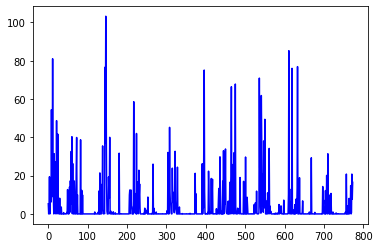

In [117]:
# Visualize the results with plotly express
plt.plot(df_pred['Actual'], color='blue', label='Actual')

In [32]:
import plotly.express as px

fig = px.line(df_pred, y=['Actual', 'Neural_Network_Tensorflow'], title='Neural Network vs Actual')
fig.show()

In [33]:
fig = px.line(df_pred, y=['Actual', 'Gradient_Boosting_XGBoost'], title='XGBoost vs Actual')
fig.show()

In [34]:
fig = px.line(df_pred, y=['Actual', 'Gradient_Boosting_LightGBM'], title='LightGBM vs Actual')
fig.show()